In [1]:
#Import knižníc
import pandas as pd
from transformers import BertTokenizer, BertForSequenceClassification, BertTokenizerFast, BertConfig
import torch
import re
import matplotlib.pyplot as plt

/Users/annahavryliak/IdeaProjects/ZS2/pythonProject/.venv/lib/python3.12/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/annahavryliak/IdeaProjects/ZS2/pythonProject/.venv/lib/python3.12/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


In [2]:
#Nacitanie datasetu
df = pd.read_csv('data/245k_tweets.csv')

In [4]:
#Spracovanie datasetu
def clean_text(text):
    #Previesť text na malé písmená
    text = text.lower()
    
    #Odstránenie adries URL
    text = re.sub(r'http\S+', '', text)
    
    #Odstránenie hashtagov (iba symbol „#“, text ponechajte)
    text = re.sub(r'#', '', text)
    
    #Odstránenie špeciálnych znakov a čísel
    text = ''.join(c for c in text if c.isalnum() or c.isspace())
    
    #Odstránenie zbytočných medzier
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

In [5]:
#Zápis očistených údajov do nového stĺpca
df['clearcontent'] = df['content'].apply(clean_text)

In [6]:
#Stiahnutie tokenizéra
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [7]:
#Tokenizácia textu s obmedzením dĺžky
def tokenize_text(text, tokenizer, max_length=128):
    tokens = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt'
    )
    return tokens['input_ids'], tokens['attention_mask']

In [8]:
#Vytvorenie nových stĺpcov pre tokeny
df['input_ids'] = df['clearcontent'].apply(lambda x: tokenize_text(x, tokenizer)[0])
df['attention_mask'] = df['clearcontent'].apply(lambda x: tokenize_text(x, tokenizer)[1])

In [9]:
#Stiahnutie modelu
model_dir = 'bert_seq'

#Stiahnutie tokenizéra
tokenizer = BertTokenizerFast.from_pretrained(model_dir)

#Stiahnutie konfigurácie modelu
config_path = f"{model_dir}/config.json"
model_config = {
    "vocab_size": tokenizer.vocab_size,
    "hidden_size": 768,
    "num_labels": 2,
}

In [10]:
#Vytvorenie modelovej konfigurácie
model_config = BertConfig(
    vocab_size=tokenizer.vocab_size,
    hidden_size=768,
    num_labels=2
)

In [11]:
#Nahratie modelu s konfiguráciou
model = BertForSequenceClassification.from_pretrained(
    model_dir,
    config=model_config
)

In [12]:
#Konverzia modelu do GPU, ak je k dispozícii
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

In [13]:
#Funkcia na predpovedanie triedy (fake/real) pomocou modelu
def predict_post(input_ids, attention_mask, model, device):
    #Kontrola, či input_ids a attention_mask sú tenzory
    if not isinstance(input_ids, torch.Tensor):
        input_ids = torch.tensor(input_ids)
    if not isinstance(attention_mask, torch.Tensor):
        attention_mask = torch.tensor(attention_mask)
    
    #Pridanie rozmeru banch, ak neexistuje
    if len(input_ids.shape) == 1:
        input_ids = input_ids.unsqueeze(0)
    if len(attention_mask.shape) == 1:
        attention_mask = attention_mask.unsqueeze(0)
    
    #Prenos dát do príslušného zariadenia (CPU/GPU)
    input_ids = input_ids.to(device)
    attention_mask = attention_mask.to(device)
    
    #Vyhovenie predikcii
    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
    
    #Získanie predikcie triedy
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    
    #Vrátenie výsledku (0 - fake, 1 - real)
    return "real" if predicted_class == 0 else "real"

In [14]:
#Použitie modelu na každý post v datasete
def analyze_posts(df, model, device):
    #Vytvorenie nového stĺpca pre výsledky predikcie
    df['prediction'] = df.apply(
        lambda row: predict_post(row['input_ids'], row['attention_mask'], model, device), axis=1
    )
    return df

In [15]:
#Vykonávanie následnej analýzy
df = analyze_posts(df, model, device)

In [17]:
#Ukladanie datasetu
df.to_csv('data/245_tweets_result.csv', index=False)

In [19]:
#Nacitanie noveho datasetu
df_pred = pd.read_csv('data/245_tweets_result.csv')
df_pred.head()

,content,date,location,like_count,source,total_media_shared,retweet_count,month_year,clearcontent,input_ids,attention_mask,prediction
0,1/ *NEW PAPERS ALERT*\n\nVery proud to share t...,2020-01-01,"Stanford, CA",15,Twitter Web App,0,4,2020-01,1 new papers alert very proud to share the wor...,"tensor([[ 101, 1015, 2047, 4981, 9499, 2...","tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",real
1,"Drawing from actual events, #Event201 identifi...",2020-01-02,Baltimore,1,TweetDeck,0,0,2020-01,drawing from actual events event201 identifies...,"tensor([[ 101, 5059, 2013, 5025, 2824, 2...","tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",real
2,Interesting article @PNAS on whether the Justi...,2020-01-05,Kumeyaay unceded land.,3,Twitter Web Client,0,1,2020-01,interesting article pnas on whether the justin...,"tensor([[ 101, 5875, 3720, 1052, 11649, 2...","tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",fake
3,@arambaut @WHO But batteries of tests have bee...,2020-01-05,"New York, NY",1,Twitter Web App,0,0,2020-01,arambaut who but batteries of tests have been ...,"tensor([[ 101, 19027, 11201, 4904, 2040, 2...","tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",fake
4,#Pandemic players: what do you do if you draw ...,2020-01-06,Kingdom of Fife,3,Twitter for Android,0,0,2020-01,pandemic players what do you do if you draw an...,"tensor([[ 101, 6090, 3207, 7712, 2867, 2...","tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1...",fake


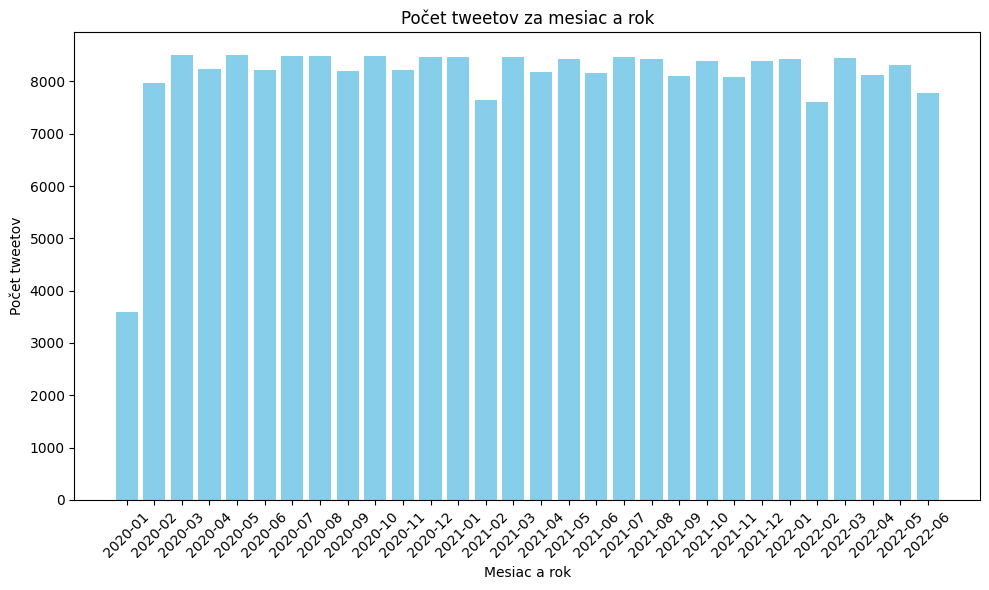

In [20]:
#Zoskupenie údajov podľa 'month_year' a spočítanie počtu tweetov
tweet_count = df_pred.groupby('month_year').size().reset_index(name='count')

#Vizualizacia počtu tweetov za kazdy mesiac
plt.figure(figsize=(10, 6))
plt.bar(tweet_count['month_year'], tweet_count['count'], color='skyblue')
plt.title('Počet tweetov za mesiac a rok')
plt.xlabel('Mesiac a rok')
plt.ylabel('Počet tweetov')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [21]:
#Odstranenie riadkov za period '2020-01'
df_pred = df_pred[df_pred['month_year'] != '2020-01']

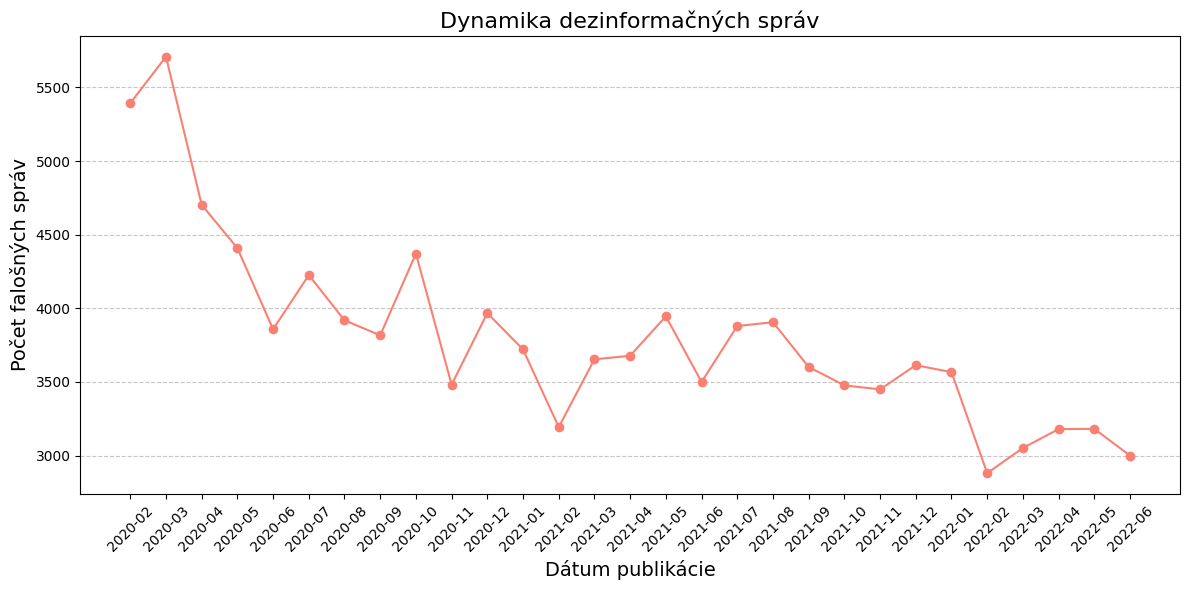

In [22]:
#Filtrovanie iba falošných postov
fake_posts = df_pred[df_pred['prediction'] == 'fake']

#Zoskupenie podľa month_year a počítanie počtu falošných postov
fake_counts = fake_posts.groupby('month_year').size().reset_index(name='count')

#Vizualizacia
plt.figure(figsize=(12, 6))
plt.plot(fake_counts['month_year'], fake_counts['count'], marker='o', color='salmon', linestyle='-')

plt.title('Dynamika dezinformačných správ', fontsize=16)
plt.xlabel('Dátum publikácie', fontsize=14)
plt.ylabel('Počet falošných správ', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()

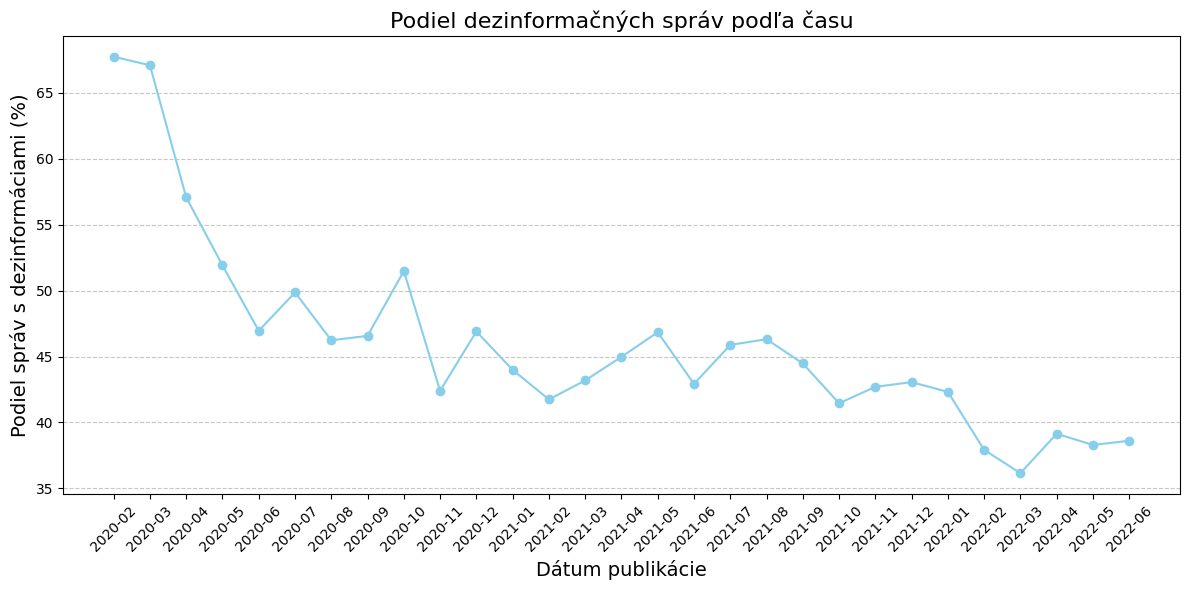

In [23]:
#Zoskupenie podľa month_year a počítanie počtu všetkých a falošných postov
grouped = df_pred.groupby('month_year').agg(
    total_posts=('prediction', 'count'),
    fake_posts=('prediction', lambda x: (x == 'fake').sum())
).reset_index()

#Výpočet percenta falošných postov za každé obdobie
grouped['fake_percentage'] = (grouped['fake_posts'] / grouped['total_posts']) * 100

#Vizualizacia
plt.figure(figsize=(12, 6))
plt.plot(grouped['month_year'], grouped['fake_percentage'], marker='o', color='skyblue', linestyle='-')

plt.title('Podiel dezinformačných správ podľa času', fontsize=16)
plt.xlabel('Dátum publikácie', fontsize=14)
plt.ylabel('Podiel správ s dezinformáciami (%)', fontsize=14)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()